# Demo to visualize target and distractor objects in ManyNames images

In [1]:
import ast
import json
import random
from io import BytesIO
from operator import itemgetter

import numpy as np
import pandas as pd
import requests
from IPython.display import display
from PIL import Image, ImageDraw

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.functional import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

## Data organization

In [2]:
# open the Manynames dataset
dir_MN = "src/data/manynames.tsv"
MN = pd.read_table(dir_MN, index_col = 0)
MN.head()

vg_image_id  vg_object_id  \
0            3       1060282   
1            4       1060306   
2            8       1060463   
3           10       1060591   
4           11       1060613   

                                             link_mn  \
0  http://object-naming-amore.upf.edu//3_1060282_...   
1  http://object-naming-amore.upf.edu//4_1060306_...   
2  http://object-naming-amore.upf.edu//8_1060463_...   
3  http://object-naming-amore.upf.edu//10_1060591...   
4  http://object-naming-amore.upf.edu//11_1060613...   

                                             link_vg vg_obj_name vg_domain  \
0  https://cs.stanford.edu/people/rak248/VG_100K/...        desk      home   
1  https://cs.stanford.edu/people/rak248/VG_100K/...      carpet      home   
2  https://cs.stanford.edu/people/rak248/VG_100K/...        desk      home   
3  https://cs.stanford.edu/people/rak248/VG_100K/...        desk      home   
4  https://cs.stanford.edu/people/rak248/VG_100K/...       chair      home   

         vg_synset               vg_same_object  vg_adequacy_mean  \
0  furnishing.n.02                           {}              1.00   
1  furnishing.n.02  {'floor': 0.25, 'rug': 1.0}              1.00   
2  furnishing.n.02               {'table': 1.0}              1.00   
3  furnishing.n.02               {'table': 1.0}              0.67   
4  furnishing.n.02       {'officer chair': 1.0}              1.00   

             vg_inadequacy_type  ...  \
0                 {'None': 1.0}  ...   
1                 {'None': 1.0}  ...   
2                 {'None': 1.0}  ...   
3  {'visual': 0.3, 'None': 0.7}  ...   
4                 {'None': 1.0}  ...   

                                          singletons  \
0            {'phone': 1, 'train': 1, 'keyboard': 1}   
1                            {'mat': 1, 'ground': 1}   
2  {'keyboard': 1, 't-shirt': 1, 'chair': 1, 'shi...   
3                {'bed': 1, 'keyboard': 1, 'cpu': 1}   
4                                  {'desk chair': 1}   

                                adequacy_mean  \
0                               {'desk': 1.0}   
1  {'rug': 1.0, 'carpet': 1.0, 'floor': 0.62}   
2                {'desk': 1.0, 'table': 0.83}   
3               {'desk': 0.67, 'table': 0.67}   
4       {'officer chair': 0.33, 'chair': 1.0}   

                                     inadequacy_type total_responses  \
0                            {'desk': {'None': 1.0}}              33   
1  {'rug': {'None': 1.0}, 'carpet': {'None': 1.0}...              34   
2  {'desk': {'None': 1.0}, 'table': {'visual': 0....              32   
3  {'desk': {'None': 0.7, 'visual': 0.3}, 'table'...              33   
4  {'officer chair': {'visual': 0.3, 'linguistic'...              33   

   perc_top         H  N domain  split  \
0  1.000000  0.000000  1   home  train   
1  0.705882  1.133184  3   home  train   
2  0.843750  0.625262  2   home  train   
3  0.757576  0.799049  2   home  train   
4  1.000000  0.000000  1   home  train   

                                         same_object  
0                            {'desk': {'desk': 1.0}}  
1  {'rug': {'rug': 1.0, 'carpet': 1.0, 'floor': 0...  
2  {'desk': {'desk': 1.0, 'table': 1.0}, 'table':...  
3  {'desk': {'desk': 1.0, 'table': 1.0}, 'table':...  
4  {'officer chair': {'officer chair': 1.0, 'chai...  

[5 rows x 27 columns]

In [3]:
# download object detections file
dir_detections = "src/data/manynames_detections.tsv"

detections = pd.read_table(dir_detections, index_col = 0)
detections.head()

link_vg              tar_xywh  \
0  https://cs.stanford.edu/people/rak248/VG_100K/...  [131, 233, 506, 245]   
1  https://cs.stanford.edu/people/rak248/VG_100K/...    [2, 349, 622, 130]   
2  https://cs.stanford.edu/people/rak248/VG_100K/...   [14, 388, 553, 212]   
3  https://cs.stanford.edu/people/rak248/VG_100K/...    [0, 383, 471, 216]   
4  https://cs.stanford.edu/people/rak248/VG_100K/...  [250, 173, 290, 427]   

                                       detected_xyxy  \
0  [[161.85691833496094, 274.9837951660156, 333.1...   
1  [[185.3144989013672, 217.41111755371094, 302.3...   
2  [[283.2087707519531, 376.0804138183594, 432.39...   
3  [[1.883772611618042, 59.3803825378418, 455.274...   
4  [[56.002288818359375, 167.54083251953125, 224....   

                                             classes  \
0  [71, 125, 462, 71, 125, 119, 395, 170, 462, 17...   
1  [166, 166, 248, 117, 453, 106, 166, 248, 136, ...   
2  [71, 125, 847, 248, 177, 170, 168, 125, 506, 1...   
3  [248, 248, 498, 125, 498, 200, 50, 106, 200, 1...   
4  [71, 125, 182, 125, 200, 453, 106, 200, 182, 1...   

                                              scores  
0  [0.8130906820297241, 0.7951371073722839, 0.790...  
1  [0.9777079224586487, 0.9654757976531982, 0.815...  
2  [0.9240149855613708, 0.8257272839546204, 0.790...  
3  [0.8719078302383423, 0.8296729326248169, 0.812...  
4  [0.8825466632843018, 0.7919272184371948, 0.692...

## Distractor selection

### Based on size, IoU, and similarity with the target

We see what happens if we select target and distractors based on the following criteria:
- low intersection over union with target
- size (ideally, not too small)
- maximum similarity with the target, to generate hard cases

In [38]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [39]:
# initialize pre-trained ResNet model
model = models.resnet50(pretrained=True)
model = model.eval()

In [40]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_image_features(img, bbox):
    x1, y1, x2, y2 = bbox
    cropped_img = img.crop((x1, y1, x2, y2))
    img_tensor = preprocess(cropped_img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_tensor)
    return features

In [41]:
MN_images = [i for i in MN['link_vg']]
tar_xywh = [ast.literal_eval(i) for i in MN['bbox_xywh']]
d_xyxy = [list(ast.literal_eval(i)) for i in detections['detected_xyxy']]

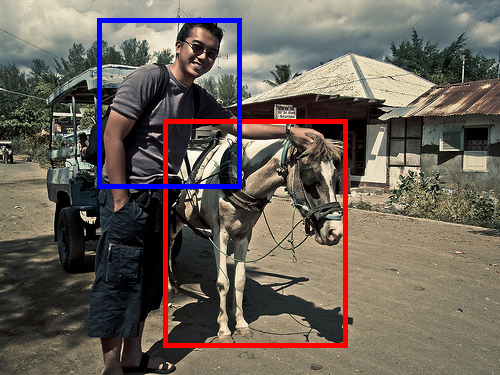

Image 1
Distractor similarity = 0.6487893462181091





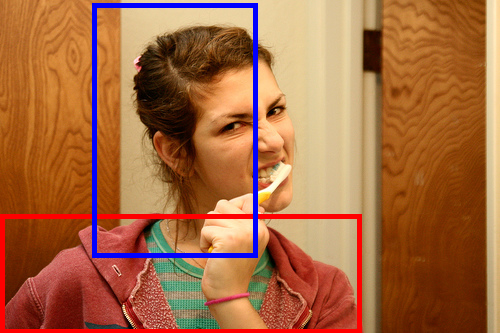

Image 2
Distractor similarity = 0.6923729777336121





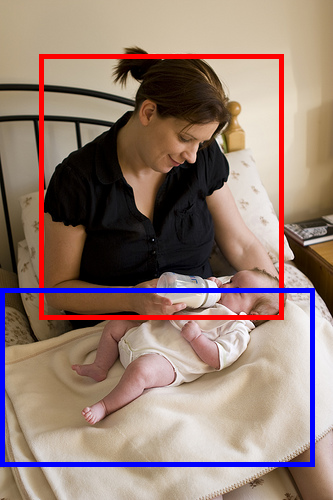

Image 3
Distractor similarity = 0.6243897676467896





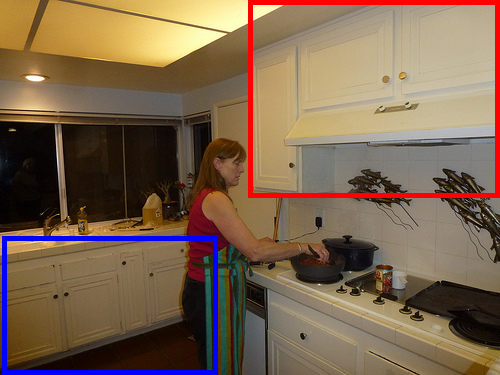

Image 4
Distractor similarity = 0.7227195501327515





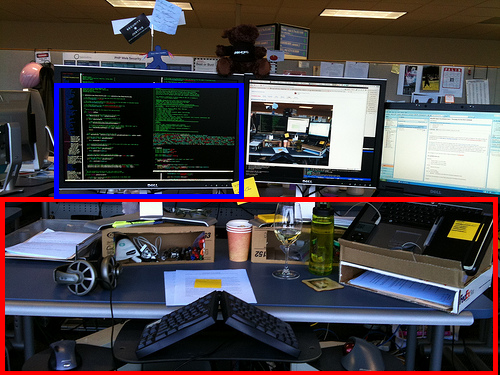

Image 5
Distractor similarity = 0.6437343955039978





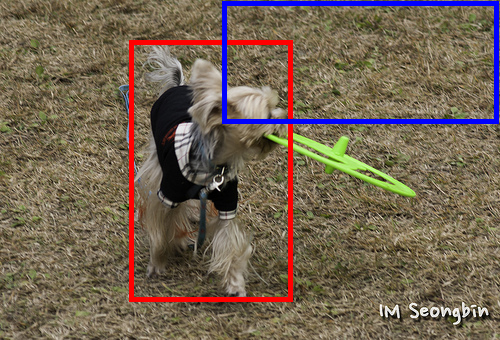

Image 6
Distractor similarity = 0.6410901546478271





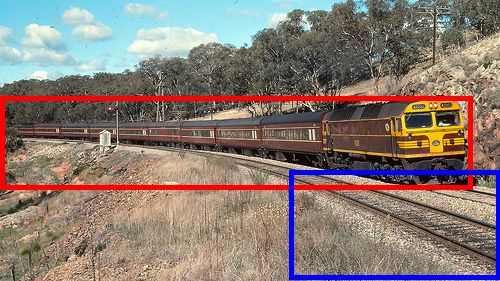

Image 7
Distractor similarity = 0.7234297394752502





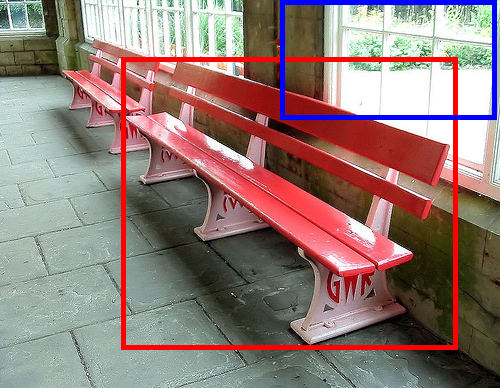

Image 8
Distractor similarity = 0.6793609261512756





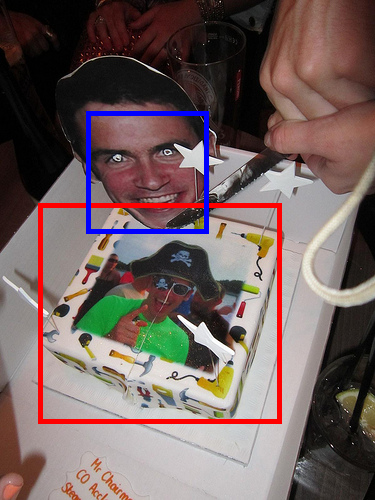

Image 9
Distractor similarity = 0.6232197284698486





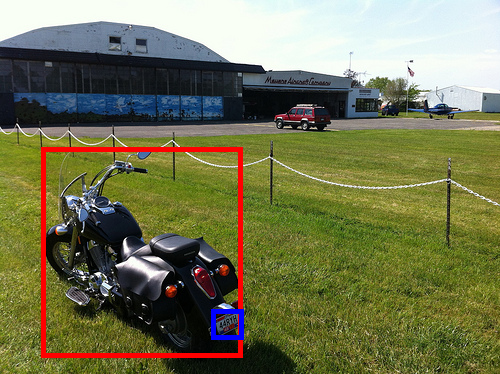

Image 10
Distractor similarity = 0.47471103072166443





In [42]:
iou_threshold = 0.1 
size_threshold = 0 # size as proportion of the entire image size
max_images_plot = 10 # how many images to visualize
random.seed(0)

zipped = list(zip(MN_images, tar_xywh, d_xyxy))
random.shuffle(zipped)

counter = 0
for url, bbox, img_detections in zipped:
    if counter >= max_images_plot:
        break

    counter += 1

    # open image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_size = img.size[0] * img.size[1]
    x, y, w, h = bbox
    tar_bbox = {'x1': x,
                'x2': x + w,
                'y1': y,
                'y2': y + h}
    shape_tar = [(tar_bbox['x1'], tar_bbox['y1']), (tar_bbox['x2'], tar_bbox['y2'])]

    # target bbox
    img1 = ImageDraw.Draw(img)
    img1.rectangle(shape_tar, outline="red", width=5)

    # get features of target object
    tar_features = get_image_features(img, [tar_bbox['x1'], tar_bbox['y1'], tar_bbox['x2'], tar_bbox['y2']])

    # get distractors
    candidates = []
    for dist_bbox in img_detections:  
        x1, y1, x2, y2 = dist_bbox
        dist_w = abs(x2 - x1)
        dist_h = abs(y2 - y1)
        dist_size = dist_w * dist_h
        d_bbox = {'x1': x1,
                'x2': x2,
                'y1': y1,
                'y2': y2}
        iou = get_iou(d_bbox, tar_bbox)
        if iou <= iou_threshold and dist_size / img_size > size_threshold:
            candidates.append(d_bbox)

    # find most similar distractor among candidates
    max_similarity = -float('inf')
    best_distractor_bbox = None

    for dist_bbox in candidates:
        dist_features = get_image_features(img, [dist_bbox['x1'], dist_bbox['y1'], dist_bbox['x2'], dist_bbox['y2']])
        similarity = cosine_similarity(tar_features, dist_features).item()

        if similarity > max_similarity:
            max_similarity = similarity
            best_distractor_bbox = dist_bbox

    if best_distractor_bbox:
        shape_dist = [(best_distractor_bbox['x1'], best_distractor_bbox['y1']),
                              (best_distractor_bbox['x2'], best_distractor_bbox['y2'])]
        img2 = ImageDraw.Draw(img)
        img2.rectangle(shape_dist, outline="blue", width=5)
        display(img)
        print("Image", counter)
        print("Distractor similarity =", max_similarity)
        print("\n\n")
    else:
        display(img)
        print("Image", counter)
        print("No suitable distractor found")
        print("\n\n")
